In [1]:
import dgl
from dgl.data import TreeCycleDataset
import torch
import torch_geometric
import torch_geometric.transforms as T

In [2]:
import argparse
import time
import easydict
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import torch_geometric.utils
from torch_geometric.utils.convert import from_networkx
from torch_geometric.logging import log
import os
import pandas as pd
import glob
import pickle

In [4]:
dataset = TreeCycleDataset()
g = dataset[0]

Done loading data from cached files.


In [5]:
#Download file Tree_Cycle.pkl from the dataset in https://github.com/Graph-and-Geometric-Learning/D4Explainer. Tree_Cycle.pkl is required for the train/val/test splits.

In [6]:
with open('Tree_Cycle.pkl', 'rb') as fin:
    adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, edge_label_matrix  = pickle.load(fin)

In [7]:
g.ndata["train_mask"] = torch.tensor(train_mask)
g.ndata["val_mask"] = torch.tensor(val_mask)
g.ndata["test_mask"] = torch.tensor(test_mask)

In [8]:
data = torch_geometric.utils.from_dgl(g)
data.x = data.feat
data.y = data.label
data.pop('feat')
data.pop('__orig__')
data.pop('label')
#data

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,

In [9]:
x = torch.tensor([1.0]*2)
data.x = x.repeat(data.x.shape[0],1)

In [10]:
data.x

tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        ...,
        [1., 1.],
        [1., 1.],
        [1., 1.]])

In [11]:
data.x.shape

torch.Size([871, 2])

In [12]:
data

Data(edge_index=[2, 967], train_mask=[871], val_mask=[871], test_mask=[871], x=[871, 2], y=[871])

In [13]:
parser = argparse.ArgumentParser()
args = easydict.EasyDict({
    "dataset": 'TreeCycle',
    #"batch_size": 128,
    # "hidden_channels": 64,
    # "lr": 0.0005,
    "epochs": 2000,
})

In [14]:
device = 'cpu'
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels,
                             )
        self.conv2 = GCNConv(hidden_channels, hidden_channels,
                             )
        self.conv3 = GCNConv(hidden_channels, out_channels,
                             )

    def forward(self, x, edge_index, edge_weight=None):
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index, edge_weight)
        return x


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)

    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x, data.edge_index).argmax(dim=-1)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        accs.append(int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
    return accs

In [15]:
def evaluate_gnn(graph):
    with torch.no_grad():
        model.eval()
        graph = graph.to(device)
        # The pred is not used for accuracy, the softmax is used
        out = model(graph.x.float(), graph.edge_index, graph.batch)
        pred = out.argmax(dim=-1)

        # Getting class prediction probabilities from the softmax layer
        softmax = out.softmax(dim=-1)

        return softmax.tolist()

In [16]:
graphs_path = '../../graph generator/diffusion models/sampled_graphs_diffusion/' 
print('Original no of graphs:',len([name for name in glob.iglob(graphs_path + 'TreeCycle_10to15/*.gexf')]))

Original no of graphs: 1398


In [17]:
avg_max_pred_list = []
max_pred_list = []
softmax_dict_list = []
class_graphid_list = []

In [18]:
def get_max_pred(softmax_dict,i):
    #Getting the list of predictions for each class
    prob_class0_dict = {}
    prob_class1_dict = {}

    for nodeid in softmax_dict:
        list0= []
        list1= []

        if len(softmax_dict[nodeid]) > 0:
            list0= []
            list1= []
    
            for prob in softmax_dict[nodeid]:        
                list0.append(prob[0])        
                list1.append(prob[1]) 
    
         #Taking max probability of all nodes of each class in a graph
        if len(list0) != 0:
            prob_class0_dict[nodeid]=max(list0)
        if len(list1) != 0:    
            prob_class1_dict[nodeid]=max(list1)

    max_pred0 = max(prob_class0_dict.values())
    max_pred1 = max(prob_class1_dict.values())

    print('Run'+str(i), max_pred0, max_pred1)
    max_pred_list.append([max_pred0, max_pred1])

    softmax_dict_list.append(softmax_dict)
    
    avg_max_pred = (max_pred0+max_pred1)/2
    avg_max_pred_list.append(avg_max_pred)
    
    class0_graphid = max(prob_class0_dict, key=prob_class0_dict.get)
    class1_graphid = max(prob_class1_dict, key=prob_class1_dict.get)

    class_graphid_list.append([class0_graphid,class1_graphid])

In [19]:
for i in range(0,10):
    device = 'cpu'
    model = GCN(
        in_channels=data.x.shape[1],
        hidden_channels=128,
        out_channels=2,
    ).to(device)
    
    optimizer = torch.optim.Adam([
    dict(params=model.conv1.parameters(), weight_decay=5e-4),
    dict(params=model.conv2.parameters(), weight_decay=0),
    dict(params=model.conv3.parameters(), weight_decay=0)
    ], lr=0.00005)  # Only perform weight-decay on first convolution.

    best_val_acc = test_acc = 0
    start_patience = patience = 100
    #times = []
    for epoch in range(1, 2000 + 1):
        loss = train()
        train_acc, val_acc, tmp_test_acc = test()
        if val_acc > best_val_acc:
            #best_val_acc = val_acc
            test_acc = tmp_test_acc
        if epoch%100==0:
            log(Epoch=epoch, Loss=loss, Train=train_acc, Val=val_acc, Test=test_acc)
        #times.append(time.time() - start)
    
        if (val_acc>best_val_acc):
            patience = start_patience
            best_val_acc = val_acc
    
        else:
            patience -= 1
            
        if patience <= 0:
            print('Stopping training as validation accuracy did not improve '
                  f'for {start_patience} epochs')
            break 

    all_edges = {}
    softmax_dict = {}
    nodefeature_dict = {}
    graph_dict = {}

    for filepath in glob.iglob(graphs_path + 'TreeCycle_10to15/*.gexf'):
    
        graph = nx.read_gexf(filepath)
    
        filename = os.path.basename(filepath)
        graph_id= filename.split('.')[0]

        small_graph = from_networkx(graph)
        x = torch.tensor([1.0]*2)
        small_graph.x= x.repeat(small_graph.num_nodes,1)
        small_graph.y = small_graph.pop('node_type')

        transform = T.RandomNodeSplit(split='train_rest', num_val=0.0, num_test=1.0)
        small_graph = transform(small_graph)
    
        small_graph.pop('mode')
        small_graph.pop('weight')
        small_graph.pop('label')
        small_graph.pop('id')
        small_graph.pop('num_nodes')
        
        softmax = evaluate_gnn(small_graph)
        softmax_dict[graph_id] = softmax
        

    print("No. of graphs evaluated: ",len(softmax_dict))
    get_max_pred(softmax_dict,i)


Epoch: 100, Loss: 0.6781, Train: 0.5776, Val: 0.6552, Test: 0.5909
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  1398
Run0 0.5950760841369629 0.4536891579627991
Epoch: 100, Loss: 0.6878, Train: 0.5776, Val: 0.6552, Test: 0.5909
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  1398
Run1 0.5882276296615601 0.45723360776901245
Epoch: 100, Loss: 0.6831, Train: 0.5776, Val: 0.6552, Test: 0.5909
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  1398
Run2 0.6124445796012878 0.44522279500961304
Epoch: 100, Loss: 0.6861, Train: 0.5776, Val: 0.6552, Test: 0.5909
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  1398
Run3 0.6239323019981384 0.4394757151603699
Epoch: 100, Loss: 0.6790, Train: 0.5776, Val: 0.6552, Test: 0.5909
Stopping training as validation accuracy did not improve for 100 epochs
No. of 

In [20]:
avg_max_pred_list

[0.524382621049881,
 0.5227306187152863,
 0.5288336873054504,
 0.5317040085792542,
 0.525810033082962,
 0.5316995233297348,
 0.5399896800518036,
 0.5260397046804428,
 0.5311070084571838,
 0.5280467420816422]

In [21]:
np.mean(avg_max_pred_list)

0.5290343627333641

In [22]:
m = max(avg_max_pred_list)
index = avg_max_pred_list.index(m)
index

6

In [23]:
class_graphid_list

[['graph758', 'graph522'],
 ['graph758', 'graph522'],
 ['graph758', 'graph522'],
 ['graph758', 'graph522'],
 ['graph758', 'graph522'],
 ['graph758', 'graph522'],
 ['graph758', 'graph522'],
 ['graph758', 'graph522'],
 ['graph758', 'graph522'],
 ['graph758', 'graph522']]

In [24]:
def plot_graph(graphid, max_pred, nodetype):
    
    graph=nx.read_gexf(graphs_path + 'TreeCycle_10to15/' + graphid + '.gexf')
    
    print('Number of nodes: ',graph.number_of_nodes())
    print('graph id: ',graphid)
    print(f'Max pred probability for class {nodetype} is {max_pred}')

    nx.draw(graph, 
    with_labels=False,
             node_size=100)
    plt.show()

In [25]:
class0_graphid = class_graphid_list[index][0]
class1_graphid = class_graphid_list[index][1]

In [26]:
max_pred0 = max_pred_list[index][0]
max_pred1 = max_pred_list[index][1]

In [27]:
max_pred_list

[[0.5950760841369629, 0.4536891579627991],
 [0.5882276296615601, 0.45723360776901245],
 [0.6124445796012878, 0.44522279500961304],
 [0.6239323019981384, 0.4394757151603699],
 [0.6008396148681641, 0.45078045129776],
 [0.6231012344360352, 0.44029781222343445],
 [0.6563506126403809, 0.4236287474632263],
 [0.6013636589050293, 0.4507157504558563],
 [0.6212165951728821, 0.4409974217414856],
 [0.6096228361129761, 0.4464706480503082]]

Number of nodes:  13
graph id:  graph758
Max pred probability for class 0 is 0.6563506126403809


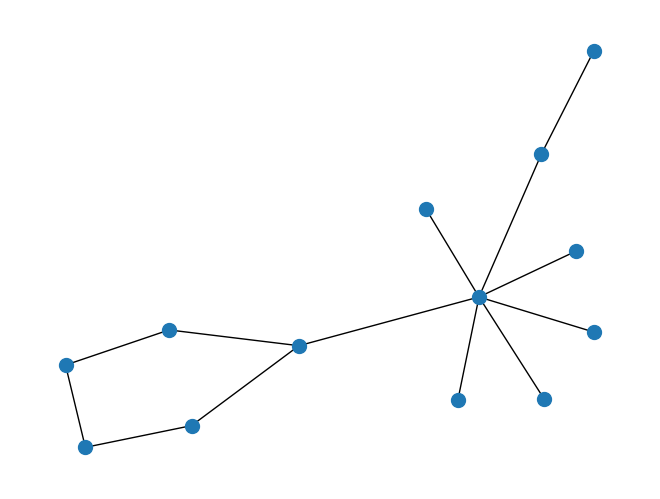

In [28]:
explanation_graph0 = plot_graph(class0_graphid, max_pred0, 0)

Number of nodes:  12
graph id:  graph522
Max pred probability for class 1 is 0.4236287474632263


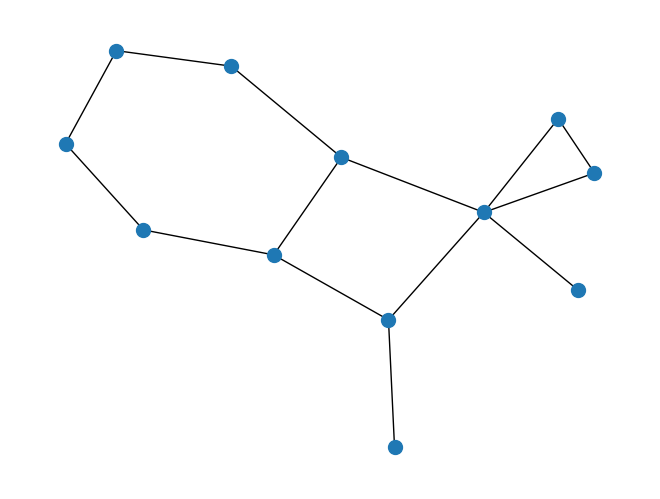

In [29]:
explanation_graph1 = plot_graph(class1_graphid, max_pred1, 1)

In [30]:
motifs_path = '../motifs/TreeCycle/'
files_motif = os.listdir(motifs_path)

In [ ]:
for index_m, file_m in enumerate(files_motif):
    filepath_m = os.path.join(motifs_path, file_m)
    print(filepath_m)

In [32]:
def get_faithfulness(graphid_list):
    class_faithfulness = []
    for graphid in graphid_list:
        expln_graph=nx.read_gexf(graphs_path + 'TreeCycle_10to15/' + graphid + '.gexf')
        
        faith_score_list = []
        for index_m, file_m in enumerate(files_motif):
            filepath_m = os.path.join(motifs_path, file_m)
            
            motif_graph = nx.read_gexf(filepath_m)

            GM = nx.algorithms.isomorphism.GraphMatcher(expln_graph,motif_graph)
            x = 1 if GM.subgraph_is_isomorphic() else 0    
            faith_score_list.append(x)

        class_faithfulness.append(np.mean(faith_score_list))

    return np.mean(class_faithfulness)

In [33]:
faithfulness_list = []

for i in range(0,10):
    faithfulness = get_faithfulness(class_graphid_list[i])

    print('Run'+str(i),faithfulness)
    faithfulness_list.append(faithfulness)
print(np.mean(faithfulness_list))

Run0 0.7166666666666667
Run1 0.7166666666666667
Run2 0.7166666666666667
Run3 0.7166666666666667
Run4 0.7166666666666667
Run5 0.7166666666666667
Run6 0.7166666666666667
Run7 0.7166666666666667
Run8 0.7166666666666667
Run9 0.7166666666666667
0.7166666666666667
